## Simple decision trees
Can you do better than the k-NN model with decision trees?

 - What accuracy can you achieve with a depth of 3?
 - Plot the corresponding tree with graphviz
 - Do you get better results if you reduce the number of dimensions with PCA first?

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import PIL.Image as Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X_tr = np.load('features_tr.npy')
y_tr = np.load('labels_tr.npy')

X_valid = np.load('features_valid.npy')
y_valid = np.load('labels_valid.npy')

X_test = np.load('features_test.npy')
y_test = np.load('labels_test.npy')

In [3]:
X_valid.shape

(139, 2048)

In [4]:
X_tr.shape

(280, 2048)

In [5]:
X_cv = np.concatenate((X_tr, X_valid), axis = 0)
X_cv.shape

(419, 2048)

In [6]:
y_cv = np.concatenate((y_tr, y_valid), axis = 0)

I concatenate the X_valid and the X_tr in one set in order to run a grid search GridSearchCV.

First I check without GridSearchCV.

In [7]:
tree_pipe = Pipeline([
    ('scaler', None),
    ('pca', PCA(n_components = 170)),
    ('simple_tree', DecisionTreeClassifier(max_depth = 3))
                ])
tree_pipe.fit(X_tr, y_tr)
accuracy = tree_pipe.score(X_valid, y_valid)
accuracy = tree_pipe.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy))
accuracy

Accuracy: 0.760


0.76

In [8]:
pd.value_counts(y_tr, normalize = True)

0.0    0.235714
1.0    0.228571
2.0    0.182143
4.0    0.150000
3.0    0.114286
5.0    0.089286
dtype: float64

In [9]:
tree_pipe_o = Pipeline([
    ('scaler', None),
    ('pca', None),
    ('simple_tree', DecisionTreeClassifier(max_depth = 3))
                ])
tree_pipe_o.fit(X_tr, y_tr)
accuracy_o = tree_pipe_o.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy_o))
accuracy_o

Accuracy: 0.700


0.7

I observe that I get better results with PCA. I assume that this happens because with PCA the complexity is reduced and that helps as a countermeasure for overfitting. 

Without PCA the accuracy is less compared to the case of having PCA (170 first components).

I apply GridSearch for the case of PCA is included and then I will plot the tree.

In [10]:
grid = { 'simple_tree__criterion' : ['gini', 'entropy']}
grid_cv = GridSearchCV( tree_pipe, grid, cv = 3, return_train_score = True, verbose = 1, n_jobs = -1)

The best soution is by default retrofitted.

In [11]:
grid_cv.fit(X_cv, y_cv)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('pca', PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('simple_tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
     ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'simple_tree__criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [12]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_simple_tree__criterion', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [13]:
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz

In [14]:
import sklearn; sklearn.__version__

'0.20.4'

We cannot give names to the features (feature_names parameter) since we use the high level features.

Let us check which is the best solution from GridSearchCV.

In [15]:
grid_cv.best_estimator_.steps

[('scaler', None),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=170, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('simple_tree',
  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'))]

I need the third step which is the simple_tree.

In [16]:
grid_cv.best_estimator_.steps[2]

('simple_tree',
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'))

From this tuple I need the second key which is the DecisionTreeClassifier with the optimum solution from GridSearchCV.

In [17]:
grid_cv.best_estimator_.steps[2][1]

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_simple_tree__criterion', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [19]:
grid_cv.cv_results_['mean_test_score']

array([0.77804296, 0.78520286])

In [20]:
tree_pipe_tuned = Pipeline([
    ('scaler', None),
    ('pca', PCA(n_components = 170)),
    ('simple_tree', DecisionTreeClassifier(max_depth = 3, criterion='entropy'))
                ])
tree_pipe_tuned.fit(X_tr, y_tr)
accuracy = tree_pipe_tuned.score(X_valid, y_valid)
accuracy = tree_pipe_tuned.score(X_test, y_test)

print('Accuracy: {:.3f}'.format(accuracy))
accuracy

Accuracy: 0.760


0.76

In [21]:
results_dt = { 'model': ['decision tree'], 'accuracy' : [accuracy] }
results_dt = pd.DataFrame(results_dt)
np.save('results_df', results_dt)
results_dt

,model,accuracy
0,decision tree,0.76


In [22]:
np.save('results_df', results_dt)

We cannot give names to the features (feature_names parameter) since we use the high level features.

In [23]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
            grid_cv.best_estimator_.steps[2][1], out_file = None,
            class_names = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van'],
            filled = True,
            rounded = True,
            proportion = True)

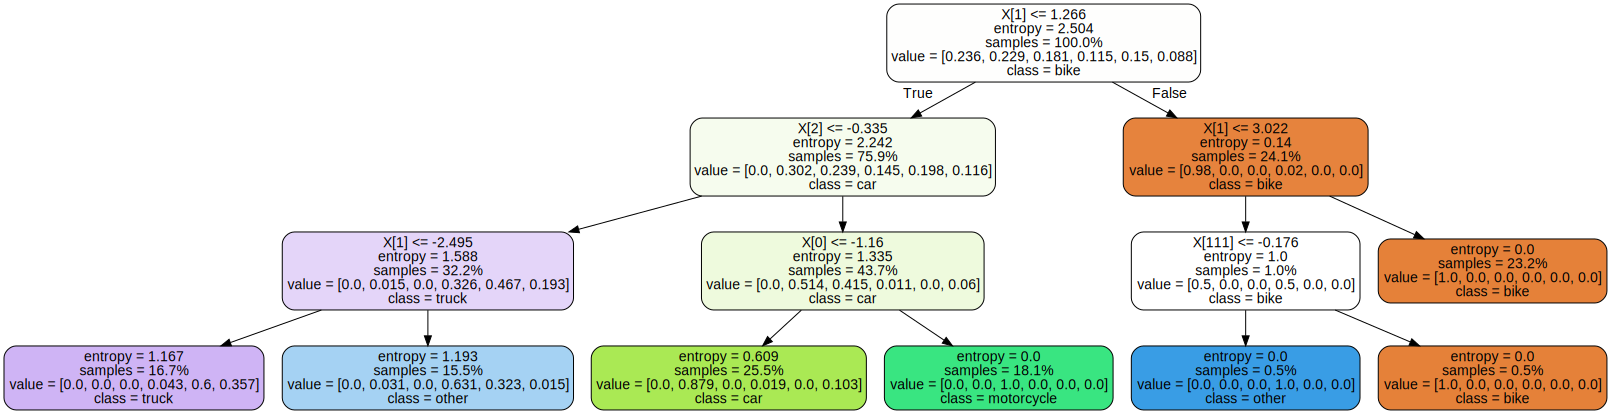

In [24]:
import graphviz
graphviz.Source(dot_data)

### Predictions

In [25]:
tree_pipe.predict(X_tr[180].reshape(1,-1))

array([2.], dtype=float32)

it is class 2

In [26]:
X_test.shape

(50, 2048)

In [27]:
tree_pipe.predict(X_test[49].reshape(1,-1))

array([4.], dtype=float32)

In [28]:
X_test[2].shape

(2048,)

In [29]:
X_tr.shape

(280, 2048)

In [30]:
X_tr[0].shape

(2048,)